Math 485 Spring 2019 Prof Lega
Supermodel Group

Created by: Alex Stoken 18 Feb 2019

Last updated: 26 Feb 2019

This file takes input data and returns the minimum connection coefficient vector C

# TODO
* [DONE] make (F,C) output a csv so that it's ready to be read in again
* add docstrings
* increase efficiency
* [DONE] wrap the animation routine in a function
* [DONE] use a random C vector to start to find other local minima
* write a routine to increase K over time

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize #has the conjugate gradient method
import scipy.integrate as integrate #ODE solver

#plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import datetime #for reference
%matplotlib inline

In [2]:
def load_lorentz_data(fname):
    """
    loads data from xlsx file, returns np.array()
    """
    data = pd.read_excel(fname, names=['x','y','z'], header = None)
    return np.array(data)
x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')


def get_lastest_C(fname):
    """
    returns last C vect from input file
    """
    C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 
    F_C_df = pd.read_csv(fname, header = None,index_col = False, names = C_headers)
    return np.array(F_C_df.iloc[-1])[1:]



In [3]:
def cost_fn(C, K =200, gamma= 0.4, delta =1, fname= None, data = None, verbose = True):
    """
    
    """
    #time from 0 to 20 seconds, with a point taken every 0.01 s
    t = np.arange(0,20,0.01)
    
    #take the integral of the lorentz system with the given Cs
    sum_k = 0
    
    #set x_o,y_o, x_o
    x_init = [x_o[0,i] for i in range(3) for i in range(3)]
    
    #do the summation in the cost function over all K
    for i in range(K): 
        #sum_k = integrate.quad(integrand,t[i], t[i]+delta,args = (data, C, t,i,0.4))[0]
        
        #each K we want to integrate the ODE w/ connection coefficiants
        sol = integrate.odeint(conn_lorentz, x_init, t, args=(C,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
        
        s_model = supermodel(sol)
        
        #set this value to 0, so we can start the addition ourselves
        integrand = 0
        
        for j in range(100):
            #range is from t_i to t_i + delta, but delta is 1 full second, so 100 of our timesteps
            model = s_model[i + j]
            truth = data[i+j,0:3]
            diff = model - truth 
            integrand += np.linalg.norm(diff)**2 * (gamma**t[i+j]) 
            
        sum_k += integrand
    
    #compute normalization constant 
    
    norm = 1/ (K * delta)
    
    #set F to be returned 
    F = sum_k * norm
    
    #write C vector to file for later access
    if fname != None:
        with open(fname,'a') as f:    
            C_str = str(C.tolist())
            C_to_file = C_str.strip('[]')
            f.write(str(F) + ',' + C_to_file +',' + '\n')
    
    #print out current F and C vec
    if verbose == True: print(F, C)
        
    #return cost F
    return F

def integrand(t, data, C, t_large,i,gamma= 0.4):
    """
    Not used at this time
    """
    sol = integrate.odeint(conn_lorentz, x_init, t_large, args=(C,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
    s_model = supermodel(sol)
    model = s_model[i]
    truth = data[i,0:3]
    diff = model - truth 
    
    return np.linalg.norm(diff)**2 * (gamma**t) 

def conn_lorentz(x_vect, t0,C, sig = [10,10,10], rho = [28,28,28], beta = [8 /3,8/3,8/3]):
    """
    Parameters:
    sigma, rho, beta - model parameters from climate data

    
    Returns: 
    l vector for next timestep 
    """
    x1,y1,z1, x2, y2, z2, x3, y3, z3 = x_vect
    
    cx12, cx13, cx23, cx21, cx31, cx32, \
    cy12, cy13, cy23, cy21, cy31, cy32, \
    cz12, cz13, cz23, cz21, cz31, cz32 = C
    
    C_x1 = cx12 * (x2 - x1) + cx13 * (x3-x1)
    C_x2 = cx21 * (x1 - x2) + cx23 * (x3-x2)
    C_x3 = cx31 * (x1 - x3) + cx32 * (x2-x3)

    C_y1 = cy12 * (y2 - y1) + cy13 * (y3-y1)
    C_y2 = cy21 * (y1 - y2) + cy23 * (y3-y2)
    C_y3 = cy31 * (y1 - y3) + cy32 * (y2-y3)
    
    C_z1 = cz12 * (z2 - z1) + cz13 * (z3-z1)
    C_z2 = cz21 * (z1 - z2) + cz23 * (z3-z2)
    C_z3 = cz31 * (z1 - z3) + cz32 * (z2-z3)
    
    sig1,sig2,sig3 = sig
    rho1,rho2,rho3 = rho
    beta1,beta2,beta3 = beta
    
    dx1 = sig1 * (y1-x1) + C_x1
    dy1 = x1 * (rho1 - z1) -y1 + C_y1
    dz1 = x1 * y1 - beta1 *z1 +C_z1

    dx2 = sig2 * (y2-x2) + C_x2
    dy2 = x2 * (rho2  -z2) - y2 + C_y2
    dz2 = x2 * y2 - beta2 *z2 +C_z2

    dx3 = sig3 * (y3-x3) + C_x3
    dy3 = x3 * (rho3 - z3) - y3 + C_y3
    dz3 = x3 * y3 - beta3 *z3 +C_z3
    
    
    return [dx1,dy1,dz1,dx2,dy2,dz2,dx3,dy3,dz3]

def supermodel(sol):
    """
    input is three 3-vectors of model solns
    
    returns 3 vector of supermodel solns
    """
    x_s = 1/3 * (sol[:,0:3] + sol[:,3:6] + sol[:,6:9])
    return x_s

In [49]:
def run_sm_optimization(last_fname = None):
    """
    
    """
    #set parameter values
    gamma = 0.4
    delta = 1
    K = 200


    #load data and set initial conditions
    x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')
    x_init = [x_o[0,i] for i in range(3) for i in range(3)]
    C_init = np.zeros(18)
    t = np.arange(0,20,0.01)
    
    
    C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 

    
    if last_fname != None:
        C_opt_guess = get_lastest_C(last_fname)
    else:
        C_opt_guess = 10*np.random.random(18)

        
        
    #find true values for comparison
    truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
    data = truth[:, 0:3]
    

    #prepare optimization
    fname = 'F_list_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + '.csv'
    f = open(fname, 'w+')
    f.close()
    
    print(f'SM optimization beginning with C = {C_opt_guess}')
    
    C = optimize.fmin_cg(cost_fn, C_opt_guess, args=(K,gamma,delta, fname, data), full_output=True)

    print(C)
    print('SM has been optimized')
    
    return C


# VISUALIZE SUPERMODEL VS DATA (ANIMATION)

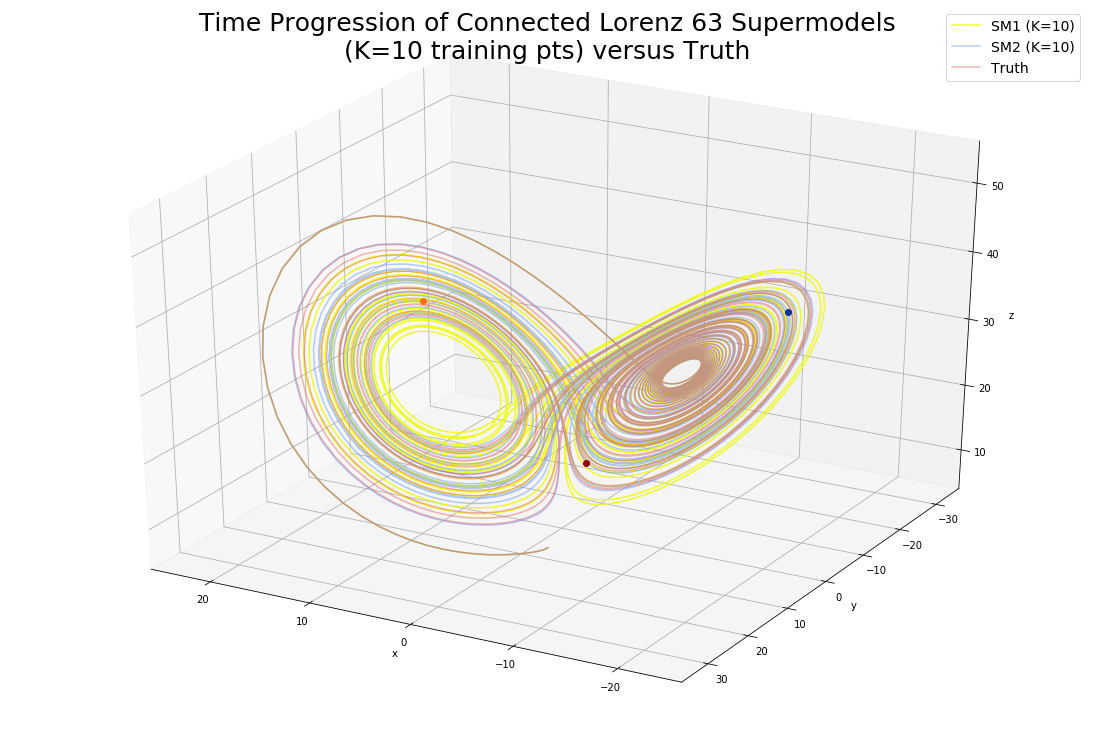

In [48]:
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

mp4name = 'sm1_sm2_truthk10'

C_opt = get_lastest_C('F_list_2019-02-28_10:02:58.csv')
C_opt2 = get_lastest_C('F_list_2019-03-16_22:02:39.csv')

C_init = np.zeros(18)
t = np.arange(0,1000,0.01)
x_init = [x_o[0,i] for i in range(3) for i in range(3)]
model_C_opt = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
model_C_opt2 = integrate.odeint(conn_lorentz, x_init, t, args=(C_opt2,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
data = truth[:, 0:3]
x_s = supermodel(model_C_opt)
x_s2 = supermodel(model_C_opt2)

fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('tight')

"""
colors = ['xkcd:azure','xkcd:wheat']
c_pts = ['navy', 'orange']
"""
colors = [(238/255, 251/255, 3/255, 0.85),(117/255, 160/255, 255/255, 0.54), (224/255, 91/255, 91/255, 0.45)]
c_pts =['xkcd:orange',(6/255, 49/255, 166/255,1), 'xkcd:crimson']

labels = ['SM1 (K=10)', 'SM2 (K=10)', 'Truth']


#(189/255, 153/255, 8/255,1)

lines = sum([ax.plot([], [], [], '-', c=c, label = l)
         for c,l in zip(colors, labels)], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
       for c in c_pts], [])

x_t = np.asarray([x_s, x_s2, data])


ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend(fontsize = 14)
ax.set_title("""Time Progression of Connected Lorenz 63 Supermodels
(K=10 training pts) versus Truth""", fontsize= 25)
n=200



def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

def animate(i):
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

ani = animation.FuncAnimation(fig, animate, init_func=init,
                           frames=2000, interval=30, blit=True)

ani.save(mp4name+ '.mp4', writer = 'ffmpeg' )

In [79]:
def make_F_C_plots(C, data, C_names, save_name = None):

    k = 10
    fig, axs = plt.subplots(nrows=6, ncols=3, constrained_layout=True, figsize = (17,15))

    for i, ax in enumerate(axs.flatten()):
        new_C = C.copy()
        F_vals = []
        F_vals.append(cost_fn(new_C, K=k, data = data, verbose = False))
        C_vals = []
        C_vals.append(C[i])
        for j in np.arange(-3,3.5,.5):
 
            new_C[i] = C[i] + j   

            C_vals.append(new_C[i])
            F_vals.append(cost_fn(new_C, K = k, data = data, verbose = False))

        ax.scatter(C_vals[1:], F_vals[1:])
        ax.scatter(C_vals[0], F_vals[0], c='red')
        ax.set_xlabel(C_names[i], fontsize=11)
        ax.set_ylabel('F', fontsize=11)
        ax.set_title(C_names[i], fontsize=22)
        
        ax.text(.05,.8, r'$C_{opt}$ =' + str(C_vals[0]), transform = ax.transAxes)
    
    if save_name:
        plt.savefig(save_name)
    return fig

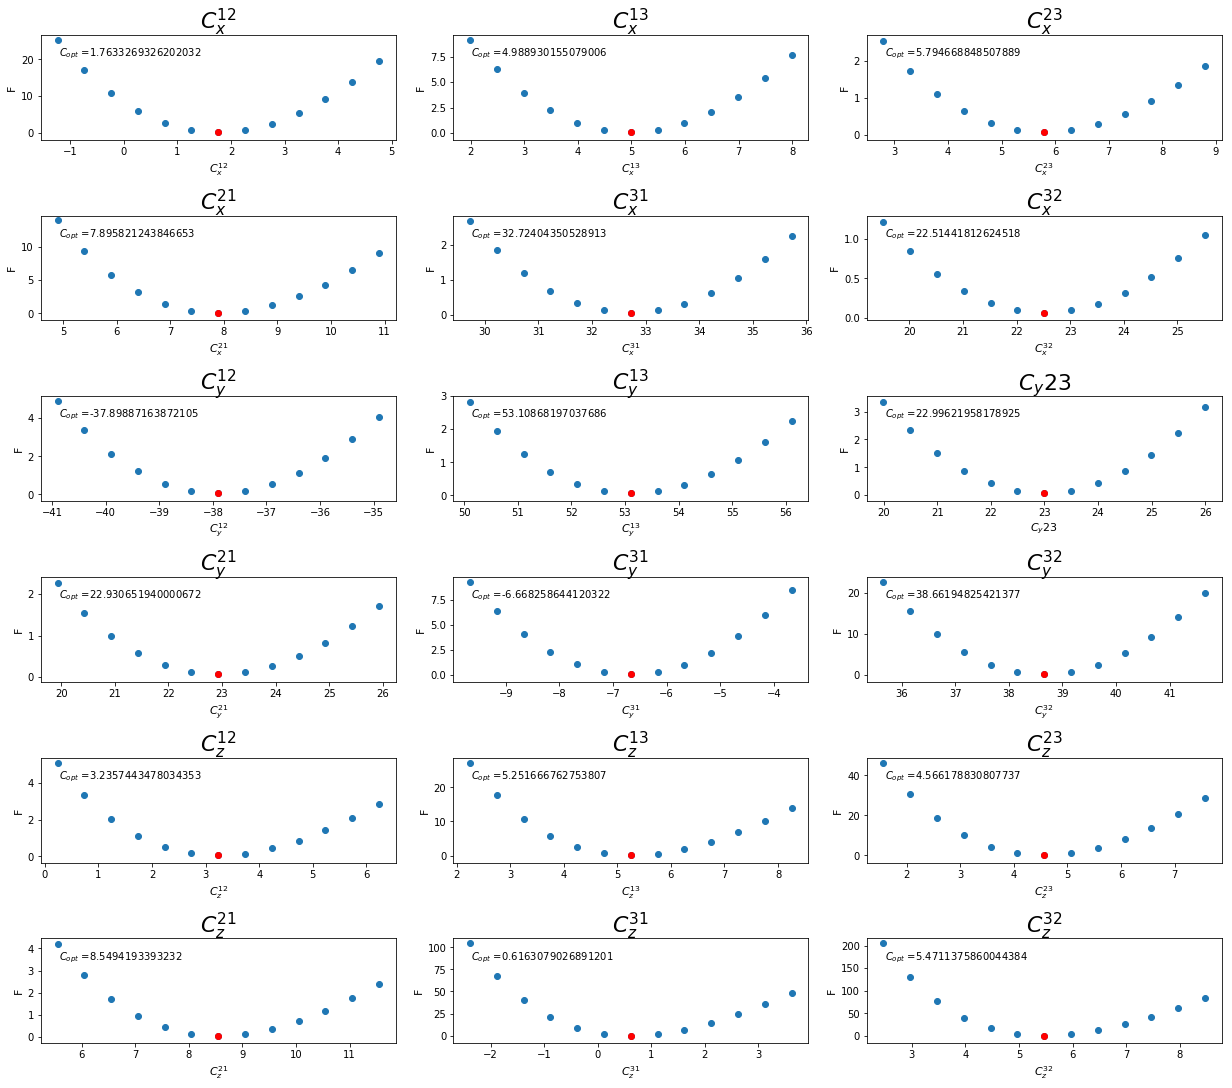

In [80]:
x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')
x_init = [x_o[0,i] for i in range(3) for i in range(3)]
C_init = np.zeros(18)
C_zeros = np.zeros(18)
t = np.arange(0,20,0.01)
C_headers = [r'$C_x^{12}$', r'$C_x^{13}$', r'$C_x^{23}$', r'$C_x^{21}$', r'$C_x^{31}$', r'$C_x^{32}$',r'$C_y^{12}$', r'$C_y^{13}$', r'$C_y{23}$', r'$C_y^{21}$', r'$C_y^{31}$', r'$C_y^{32}$', r'$C_z^{12}$', r'$C_z^{13}$', r'$C_z^{23}$', r'$C_z^{21}$', r'$C_z^{31}$', r'$C_z^{32}$'] 
truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_zeros,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
data = truth[:,0:3]
#C_latest = np.array([-1.542089124,6.555705489,6.911540307,3.992398058,30.9881037,21.40875076,-28.31332381,49.82258357,10.89791526,21.09793666,-5.222914054,27.25178126,2.079585368,5.697524811,1.586266223,6.426121113,1.193244465,3.611735179])
C_latest = get_lastest_C('F_list_2019-03-16_22:02:39.csv')
f_c_plots = make_F_C_plots(C_latest,data, C_headers, save_name = 'f_c_plots_sm2_k200_test.pdf')

# RUN ROUTINES (Functions defined above)

In [50]:
#to run from random start
#run_sm_optimization()

#to run from last place left off
last_fname = 'F_list_2019-03-16_22:02:39.csv'
C_opt = run_sm_optimization(last_fname)

#to run a new version
#C_opt = run_sm_optimization()

SM optimization beginning with C = [  1.76332693   4.98893016   5.79466885   7.89582124  32.72404351
  22.51441813 -37.89887164  53.10868197  22.99621958  22.93065194
  -6.66825864  38.66194825   3.23574435   5.25166676   4.56617883
   8.54941934   0.6163079    5.47113759]
0.06410076902146422 [  1.76332693   4.98893016   5.79466885   7.89582124  32.72404351
  22.51441813 -37.89887164  53.10868197  22.99621958  22.93065194
  -6.66825864  38.66194825   3.23574435   5.25166676   4.56617883
   8.54941934   0.6163079    5.47113759]
0.06410149622274558 [  1.76332695   4.98893016   5.79466885   7.89582124  32.72404351
  22.51441813 -37.89887164  53.10868197  22.99621958  22.93065194
  -6.66825864  38.66194825   3.23574435   5.25166676   4.56617883
   8.54941934   0.6163079    5.47113759]
0.0641017465073612 [  1.76332693   4.98893017   5.79466885   7.89582124  32.72404351
  22.51441813 -37.89887164  53.10868197  22.99621958  22.93065194
  -6.66825864  38.66194825   3.23574435   5.25166676   4.

KeyboardInterrupt: 

In [ ]:
ani.save('lorentz_sm.mp4', writer = 'ffmpeg')

# IGNORE BELOW THIS (PLAY AREA)

In [16]:
truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_zeros,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
data = truth[:,0:3]


NameError: name 'x_init' is not defined

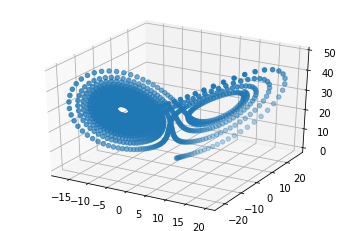

In [10]:
ax = plt.axes(projection='3d')
ax.scatter(x_o[:,0],x_o[:,1],x_o[:,2])

In [11]:

C_opt_guess = np.zeros(18)
C_init = np.ones(18)

x_init = [x_o[0,i] for i in range(3) for i in range(3)]

out = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))

NameError: name 't' is not defined

NameError: name 'out' is not defined

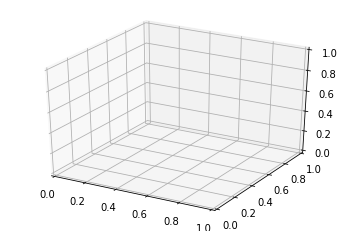

In [12]:
ax = plt.axes(projection='3d')
ax.scatter(out[:2000,0],out[:2000,1],out[:2000,2])
ax.scatter(out[:2000,3],out[:2000,4],out[:2000,5], c='red')
ax.scatter(out[:2000,6],out[:2000,7],out[:2000,8],c='yellow')
x_s = supermodel(out )
ax.scatter(x_s[:,0], x_s[:,1],x_s[:,2] ,c='black')

In [13]:
x_s[:,0:3]

NameError: name 'x_s' is not defined

NameError: name 'truth' is not defined

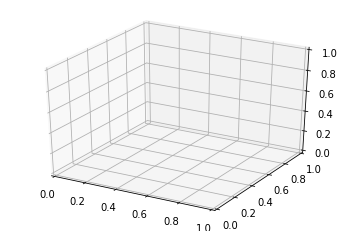

In [14]:
import mpld3
ax = plt.axes(projection='3d')
n=5000
#ax.scatter(out[:n,0],out[:n,1],out[:n,2], c = 'blue')
#ax.scatter(out[:n,3],out[:n,4],out[:n,5], c='red')
#ax.scatter(out[:n,6],out[:n,7],out[:n,8],c='yellow')
ax.scatter(truth[:n,6],truth[:n,7],truth[:n,8])
x_s = supermodel(out )
ax.scatter(x_s[:n,0], x_s[:n,1],x_s[:n,2] ,c='black')


In [ ]:
C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 
F_C_df = pd.read_csv('F_list_2019-02-27_02:57:10.csv', header = None,index_col = False, names = C_headers)
C_last = np.array(F_C_df.iloc[-1])[1:]
for c in F_C_df.columns:
    F_C_df.plot( x= c, y = 'F', kind = 'scatter', ylim = (0,30))
    

In [34]:
f_v_plots.savefig('f_c_plots.png')